In [516]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error

%matplotlib inline

In [517]:
df = pd.read_csv('train-2.csv')
df_test = pd.read_csv('test-2.csv')
df.columns

Index(['house_id', 'dt', 'n_bedrooms', 'n_bathrooms', 'n_floors', 'S_above',
       'S_basement', 'S_living', 'S_lot', 'lat', 'long', 'year_built',
       'status', 'price_target'],
      dtype='object')

In [518]:
def preprocess_data(df_input):
    df_output = df_input.copy()
    df_output.fillna(0, inplace=True)

    df_output['dt'] = df_output.dt.str.split('-').str[1].astype(int)
    #df_output['dt'] = df_output['dt'].map(pd.Timestamp.to_julian_date)
    #df_output['S_total'] = df_output['S_living'] + df_output['S_above'] + df_output['S_basement']
    #df_output['S_total_lot'] = df_output['S_total'] + df_output['S_lot']
    #df_output['has2ndfloor'] = df_output['n_floors'].apply(lambda x: 1 if 1 < x <= 2 else 0)
    #df_output['has3ndfloor'] = df_output['n_floors'].apply(lambda x: 1 if 2 < x <= 3 else 0)
    #df_output['has4ndfloor'] = df_output['n_floors'].apply(lambda x: 1 if 3 < x <= 4 else 0)
    #df_output['haslot'] = df_output['S_lot'].apply(lambda x: 1 if x > 0 else 0)
    
    #columns = ['n_bedrooms', 'n_bathrooms', 'S_above', 'S_living', 'S_lot']

    df_output['n_bedrooms'] = df_output['n_bedrooms'].apply(lambda x: df_output['n_bedrooms'].median() if x > 12 else x)
    df_output['S_lot'] = df_output['S_lot'].apply(lambda x: df_output['S_lot'].median() if x >= 500000 else x)
    #df_output['S_basement'] = df_output['S_basement'].apply(lambda x: df_output['S_basement'].median() if x >= 3000 else x)
    #df_output['S_above'] = df_output['S_above'].apply(lambda x: df_output['S_above'].median() if x >= 6000 else x)
    df_output['long'] = df_output['long'].apply(lambda x: df_output['long'].median() if x >= -121.6 else x)
    
    df_output = df_output.drop(['house_id', 'dt', 'status', 'year_built', 'n_floors'], axis=1)
    
    return df_output

n_bedrooms


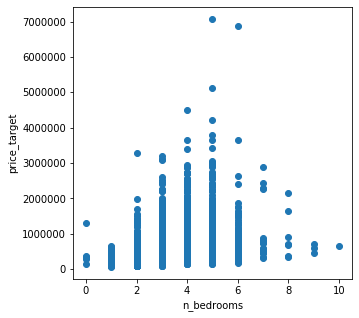

n_bathrooms


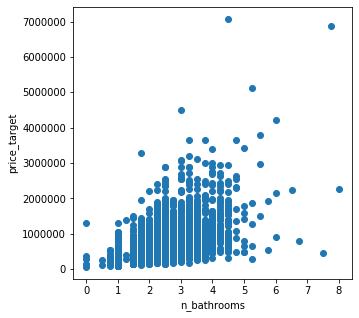

S_above


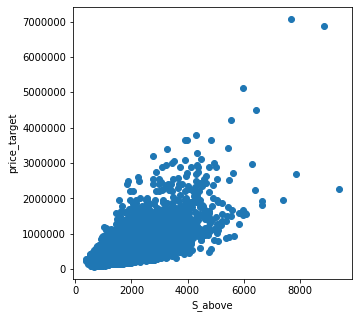

S_basement


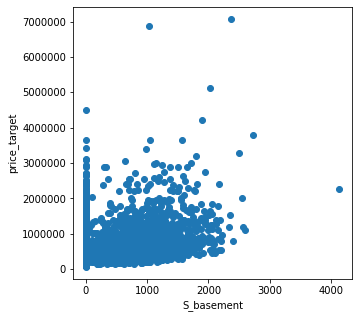

S_living


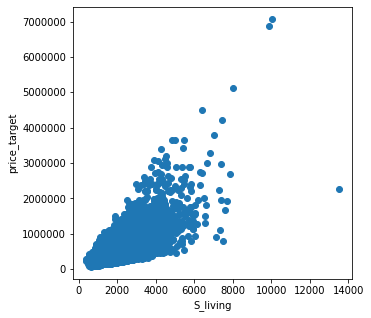

S_lot


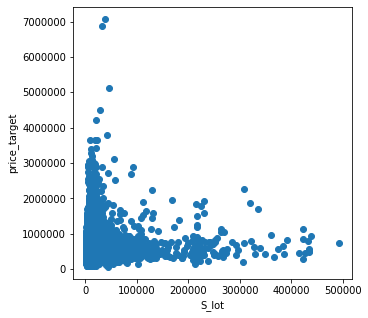

lat


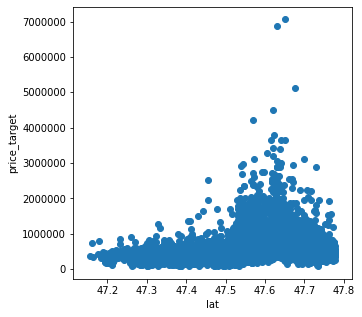

long


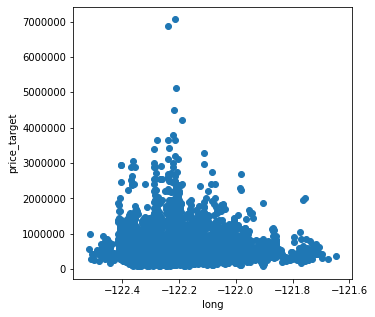

price_target


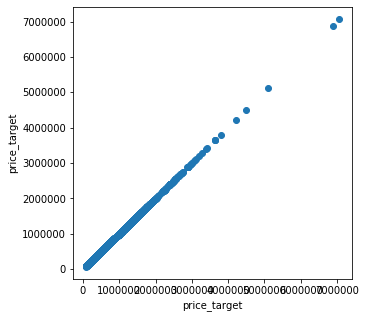

In [519]:
df_train_preproc = df.pipe(preprocess_data)
df_train_preproc.head()
for column in df_train_preproc.columns:
    plt.figure(figsize=(5,5))
    plt.scatter(df_train_preproc[column], df_train_preproc['price_target'])
    plt.ylabel('price_target')
    plt.xlabel(column)
    print(column)
    plt.show()

In [520]:
df_train_preproc;

In [521]:
def X_y_split(data, target_column):
    blacked_columns = set([target_column])
    features = [f for f in data.columns if f not in blacked_columns]
    X = data[features].values
    y = data[target_column]

    return X, y, features

In [522]:
target_column = 'price_target'
X, y, training_features = X_y_split(df_train_preproc, target_column)

In [523]:
def rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_log_error(y_actual, y_pred))

In [524]:
scores_test = []
scores_train = []

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

for k in range(1, 20):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_knn = KNeighborsRegressor(n_neighbors=k, p=1)
    #model_tree = DecisionTreeRegressor(max_depth=k)
    model_knn.fit(X_train_scaled, y_train)
    #model_tree.fit(X_train_scaled, y_train)
    
    y_hat_test = model_knn.predict(X_test_scaled)
    #y_hat_test2 = model_tree.predict(X_test_scaled)
    
    y_hat_train = model_knn.predict(X_train_scaled)
    #y_hat_train2 = model_tree.predict(X_train_scaled)
    
    scores_test.append((rmsle(y_test, y_hat_test)))
    #scores_test.append((k, rmsle(y_test, y_hat_test)))
    
    scores_train.append((rmsle(y_train, y_hat_train)))
    #scores_train.append((k, rmsle(y_train, y_hat_test)))
    
    print(k, rmsle(y_test, y_hat_test))
    
# plt.plot(scores_test, label='test')
# plt.plot(scores_train, label='train')
# plt.xlabel('n_neighbours')
# plt.ylabel('rmsle')
# plt.legend()

1 0.2949547257129392
2 0.2531312694100653
3 0.23990819962434032
4 0.2360777061050573
5 0.23388939871185427
6 0.23250729239500215
7 0.23055052447344937
8 0.22917504882174744
9 0.23021711593101943
10 0.22945037227241255
11 0.22869550014565188
12 0.22835595916262857
13 0.2282362205132997
14 0.22964758881557215
15 0.22969524109945635
16 0.22996264483753784
17 0.23031179280538014
18 0.2304706298993888
19 0.23092366606036313


In [525]:
model_knn = KNeighborsRegressor(n_neighbors=13, p=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
results = cross_val_score(model_knn, X_scaled, y, cv=kfold, scoring='neg_mean_squared_log_error')
print(np.sqrt(abs(results.mean()))) 
# cross_val_score возвращает отрицательное значение, т.к. cross_val_score максимизирует метрики, 
# а в случае регрессии необходимо минимизировать, поэтому берется с минусом и максимизируется к нулю
# при этом возвращается отрицательный MSLE (mean_squared_log_error), а нам необходим RMSLE 
# (root_mean_squared_log_error), поэтому извлекаем корень.

# RMSLE - Root Mean Squared Log Error.
# This metric is used when the Target variable is converted into Log(Target).
# so instead of looking at RMSLE, you can look for RMSE (generally we use this). 
# You can convert the predictions to ypred = exp(predictions)
# and then np.sqrt(meansquarederror(y_test, ypred)) will give the final RMSE.

0.21909247569974794


In [526]:
scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
model = KNeighborsRegressor(n_neighbors=13, p=1)
model.fit(X_train_scaled, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=1,
                    weights='uniform')

In [527]:
df_test_preproc = df_test.pipe(preprocess_data)

In [528]:
df_test_scaled = scaler.transform(df_test_preproc)
df_test_scaled

array([[0.3       , 0.28125   , 0.17256637, ..., 0.07722096, 0.98938395,
        0.48109966],
       [0.3       , 0.3125    , 0.22676991, ..., 0.14110418, 0.17806016,
        0.57731959],
       [0.3       , 0.125     , 0.07964602, ..., 0.01972566, 0.99469197,
        0.29667812],
       ...,
       [0.5       , 0.4375    , 0.21460177, ..., 0.01457922, 0.94820653,
        0.62084765],
       [0.3       , 0.28125   , 0.10287611, ..., 0.01910492, 0.30866978,
        0.25315006],
       [0.3       , 0.125     , 0.09955752, ..., 0.01693437, 0.60817114,
        0.39747995]])

In [529]:
pred_test_df = model.predict(df_test_scaled)
pd.DataFrame(zip(df_test['house_id'], pred_test_df), columns = ['house_id','price_target']).to_csv('pred_hw4.csv', sep=',', index=False)

In [530]:
pred_test_df

array([544150.        , 472211.46153846, 323265.38461538, ...,
       647400.        , 261799.92307692, 308603.84615385])

In [531]:
regressors = [
    KNeighborsRegressor(n_neighbors=9, p=1),
    KNeighborsRegressor(n_neighbors=10, p=1),
    KNeighborsRegressor(n_neighbors=11, p=1),
    KNeighborsRegressor(n_neighbors=12, p=1),
    KNeighborsRegressor(n_neighbors=13, p=1),
    KNeighborsRegressor(n_neighbors=14, p=1),
    KNeighborsRegressor(n_neighbors=15, p=1),
    KNeighborsRegressor(n_neighbors=16, p=1)
]

In [532]:
scores_test = []
scores_train = []
predictions = []

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

for model_knn in regressors:
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_knn.fit(X_train_scaled, y_train)
  
    y_hat_test = model_knn.predict(X_test_scaled)
    
    predictions.append(model_knn.predict(X_test_scaled))
    #pred_list = np.column_stack(())
    #pred_list.append(predictions)
    
    #print(np.array(predictions).T.shape)

y_hat_average = np.mean(np.array(predictions).T, axis=1)
    
print(y_hat_average)
    
scores_test.append((rmsle(y_test, y_hat_average)))

scores_test

[225256.84603591 467168.09389569 335647.28168359 ... 235426.31883741
 316976.05625278 618407.25290335]


[0.22789114448504152]

In [533]:
scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [534]:
df_test_preproc = df_test.pipe(preprocess_data)
df_test_preproc.shape

(11000, 8)

In [535]:
df_test_scaled = scaler.transform(df_test_preproc)
df_test_scaled.shape

(11000, 8)

In [536]:
scores_test = []
scores_train = []
predictions = []

for model_knn in regressors:
    pred_test_df = model_knn.predict(df_test_scaled)
    predictions.append(pred_test_df)

y_hat_average = np.mean(np.array(predictions).T, axis=1)
    
print(y_hat_average.shape)

# переобучается

(11000,)


In [537]:
# pd.DataFrame(zip(df_test['house_id'], y_hat_average), columns = [
#     'house_id','price_target']).to_csv('pred_regression_knn_ansamble.csv', sep=',', index=False)